<a href="https://colab.research.google.com/github/Andre6o6/mlcourse-2019/blob/master/AffinityProp_dummy_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check that results are close to `sklearn.cluster.AffinityPropagation`

In [0]:
preference=-50

Estimated number of clusters: 3


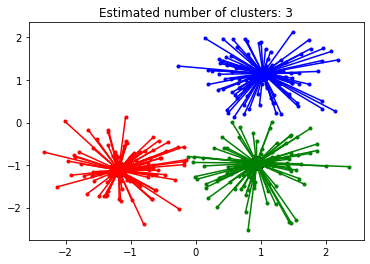

In [22]:
import numpy as np
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

# Compute Affinity Propagation
af = AffinityPropagation(preference=preference).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [0]:
n = 300
e = 300*299

dist = -metrics.euclidean_distances(X, squared=True)

edges = []

S = np.zeros(n+e)
k=0
for i in range(n):
  for j in range(n):
      if i==j:
          continue
      S[k] = dist[i,j]
      edges.append((i,j))
      k+=1

S[e:] = preference

for a in range(n):
    edges.append((a,a))

smoothing=0.5

A = np.zeros_like(S)
R = np.zeros_like(S)

In [0]:
def update_responsibility(S, A):
    tmp = A + S

    # max_{k'!=k} (a(i,k') + s(i,k'))
    M1 = np.full(n, -np.inf)  #max tmp
    M2 = np.full(n, -np.inf)  #second max (for k==argmax)
    I = np.full(n, -1)        #argmax tmp
    for i, (a,b) in enumerate(edges):   #Diag?
        if M1[a] < tmp[i]:
            M2[a] = M1[a]
            M1[a] = tmp[i]
            I[a] = b
        elif M2[a] < tmp[i]:
            M2[a] = tmp[i]

    # R = S - max{...}
    R_new = S.copy()
    for i, (a,b) in enumerate(edges):
        if b != I[a]:
            R_new[i] -= M1[a]
        else:
            R_new[i] -= M2[a]
    
    return R_new

def update_availability(R):

    r_sum = np.zeros(n)
    for i, (a,b) in enumerate(edges[:e]):
        r_sum[b] += max(0, R[i])

    r_diag = R[e:]

    A_new = np.zeros_like(A)
    for i, (a,b) in enumerate(edges[:e]):
        A_new[i] = min(0, r_diag[b] + r_sum[b] - max(0, R[i]))
    for i, (a,b) in enumerate(edges[e:]):
        A_new[e+i] = r_sum[b]

    return A_new

def find_labels(S, exemplars, Cr):

    #Assign immediate neightbours to exemplars
    M = np.full(n, -np.inf)
    I = np.full(n, -1)
    for i, (a,b) in enumerate(edges):
        if b in exemplars and M[a] <= S[i]:
            M[a] = S[i]
            I[a] = b

    #Set identity exemplars
    for i in exemplars:
        I[i] = i
        M[i] = 1

    #For unassigned nodes, set label(i)=argmax_j(A_ij+R_ij) 
    for i, (a,b) in enumerate(edges):
        if I[a] == -1 and M[a] < Cr[i]:
            M[a] = Cr[i]
            I[a] = b

    #Transitive closure
    while True:
        new_I = I.copy()
        for i, label in enumerate(new_I):
            if label not in exemplars:
                new_I[i] = new_I[label]

        if (I == new_I).all():
            break

        I = new_I
    return new_I

In [10]:
from tqdm import trange

exemplars = np.array([0])

with trange(100) as t:
    for i in t:
        R_new = update_responsibility(S, A)
        R = smoothing * R + (1 - smoothing) * R_new

        A_new = update_availability(R)
        A = smoothing * A + (1 - smoothing) * A_new
        
        old_exemplars = exemplars
        exemplars = np.where(A[e:] + R[e:] > 0)[0]
        t.set_postfix(exemplars=len(exemplars), inter=len(np.intersect1d(old_exemplars, exemplars)))

print("Found %d exemplars" % len(exemplars))
labels = find_labels(S, exemplars, A+R)
len(np.unique(labels))

Found 3 exemplars


3

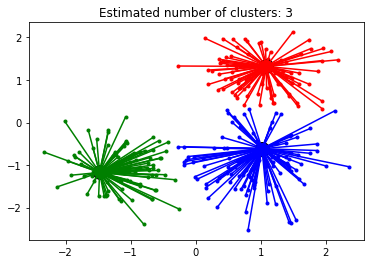

In [13]:
plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

for k, col in zip(exemplars, colors):
    class_members = labels == k
    cluster_center = X[k]
    plt.plot(X[class_members, 0], X[class_members, 1], col+'.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % len(exemplars))
plt.show()

# Check that self-similarity affects number of clusters

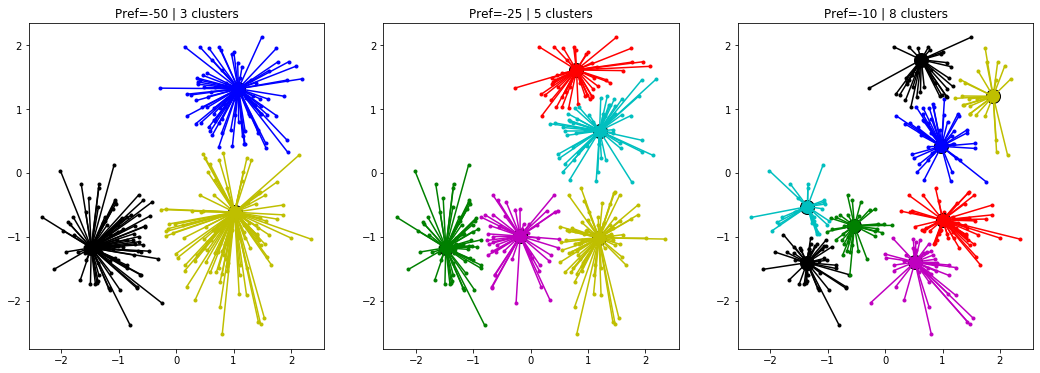

In [20]:
prefs = [-50, -25, -10]

fig, axes = plt.subplots(1, 3, figsize=(18,6))
axes = axes.flatten()

for pref, ax in zip(prefs, axes):
    S[e:] = pref

    A = np.zeros_like(S)
    R = np.zeros_like(S)

    #Affinity prop
    for i in range(100):
        R_new = update_responsibility(S, A)
        R = smoothing * R + (1 - smoothing) * R_new

        A_new = update_availability(R)
        A = smoothing * A + (1 - smoothing) * A_new
        
    exemplars = np.where(A[e:] + R[e:] > 0)[0]
    labels = find_labels(S, exemplars, A+R)

    #Plot
    for k, col in zip(exemplars, colors):
        class_members = labels == k
        cluster_center = X[k]
        ax.plot(X[class_members, 0], X[class_members, 1], col+'.')
        ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=14)
        for x in X[class_members]:
            ax.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

    ax.set_title("Pref={} | {} clusters".format(pref, len(exemplars)))

plt.show()